<h1> Brain Tumor Detection using Pre-Trained ResNet50 model </h1>

<p> In this notebook, detection of Brain tumors has been done by using Computer Vision. A pre-trained ResNet50 model with ImageNet weights has been used to perform this task. Keras API and tensorflow have been used in this notebook </p>

<h2> Importing necessary Libraries </h2> 

In [1]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [6]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")

All modules have been imported


<h2> Creating a required directory structure </h2>

In [10]:
clear_output()

# Define folders
folders = [
    'TRAIN/YES', 'TRAIN/NO',
    'TEST/YES', 'TEST/NO',
    'VAL/YES', 'VAL/NO'
]

# Create folders
for folder in folders:
    os.makedirs(folder, exist_ok=True)

# Show folder structure (like `tree -d`)
def print_tree(root_dir, indent=""):
    for name in sorted(os.listdir(root_dir)):
        path = os.path.join(root_dir, name)
        if os.path.isdir(path):
            print(f"{indent}|-- {name}")
            print_tree(path, indent + "    ")

print_tree(".")


|-- Brain_Tumor_Detection
    |-- no
    |-- pred
    |-- yes
|-- TEST
    |-- NO
    |-- YES
|-- TRAIN
    |-- NO
    |-- YES
|-- VAL
    |-- NO
    |-- YES


In [11]:
IMG_PATH = "Brain_Tumor_Detection"

# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [15]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [16]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

In [17]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


1800 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


600 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:04<00:00,  2.11s/it]

600 images loaded from VAL/ directory.


<h2> Plotting the number of samples in Training, Validation and Test sets </h2>

In [18]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

<h2> Let's Visualize the images we are working with </h2>

In [19]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

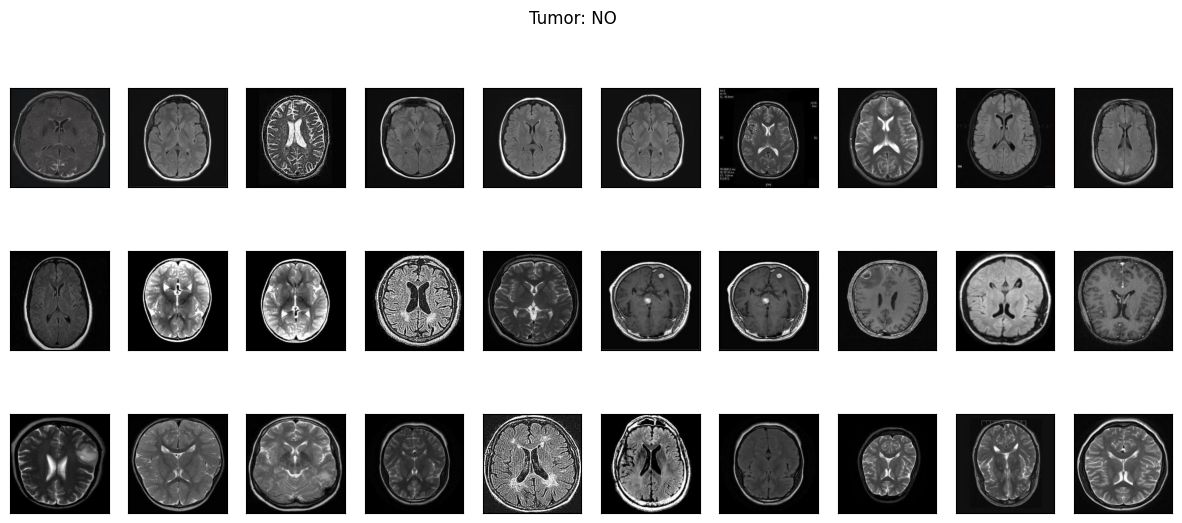

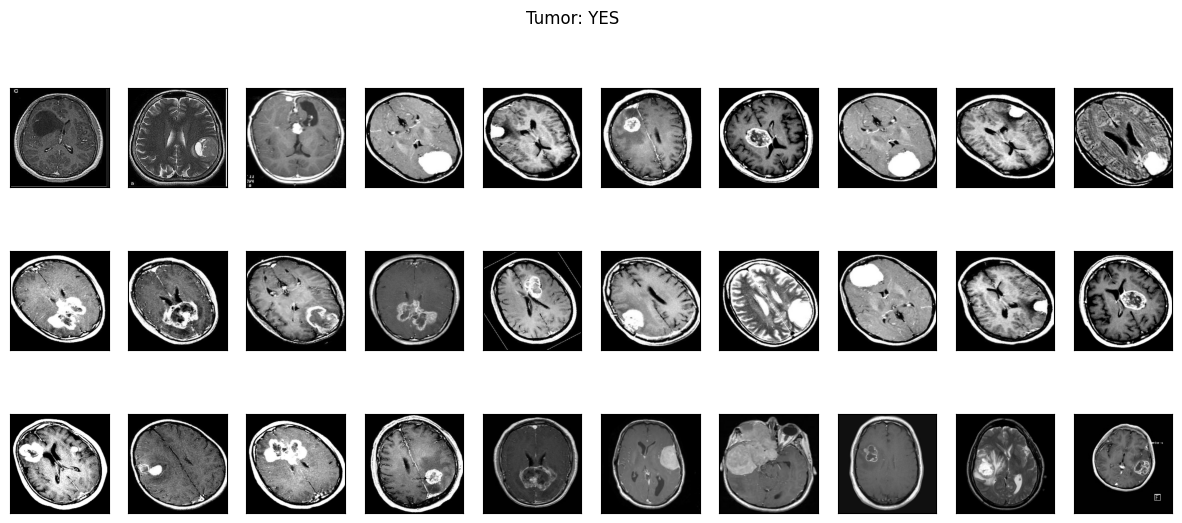

In [20]:
plot_samples(X_train, y_train, labels, 30)

<h2> Cropping the images </h2>

<p> The images we have are of different sizes. But our model accepts images of size (224*224*3) as input. To achienve this ew have to resize the images. Blindly resizing the images can lead to extreme distortions in the images. Hence, We will first crop thie images and then resize them. This will minimize the issue of distortions. </p>

<p> This cropping is done by finding contours in the images using the OpenCV Library </p>

In [25]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    final_size = (100, 100)
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(new_img, final_size)
        set_new.append(new_img)

    return np.array(set_new)

In [26]:
import imutils
img = cv2.imread('./VAL/NO/no852.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

<h2> Let's visualize how the cropping works </h2>

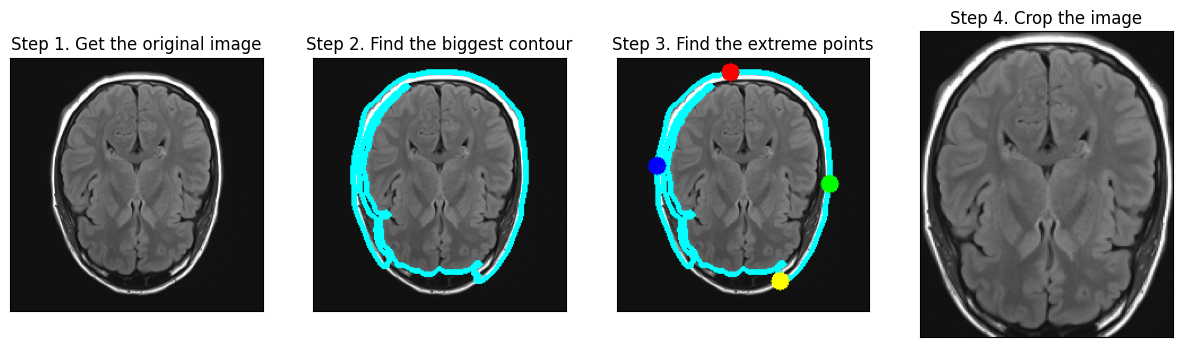

In [27]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [28]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

<h2> Let's visualize the images after being cropped </h2>

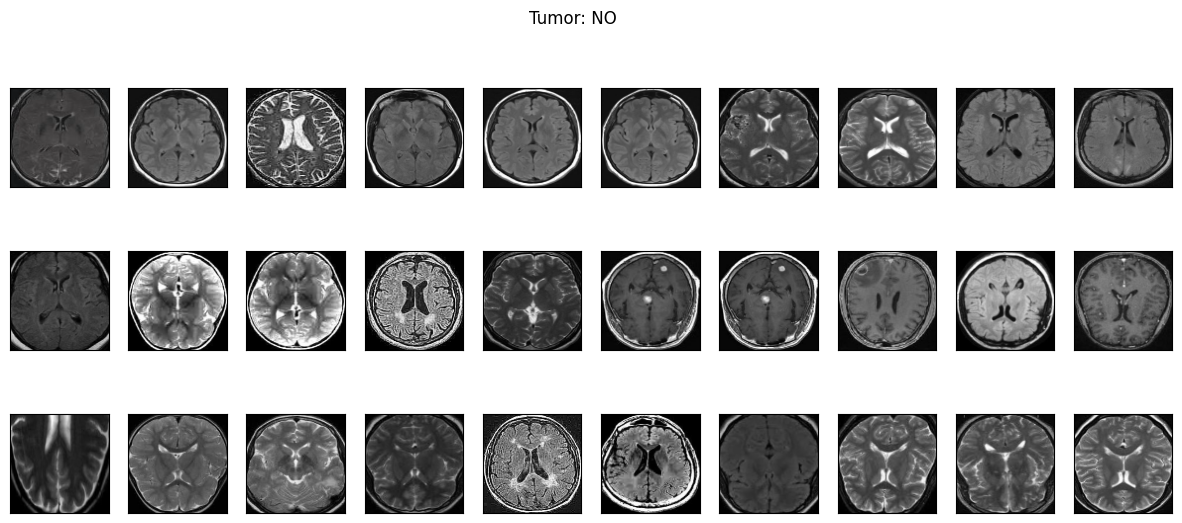

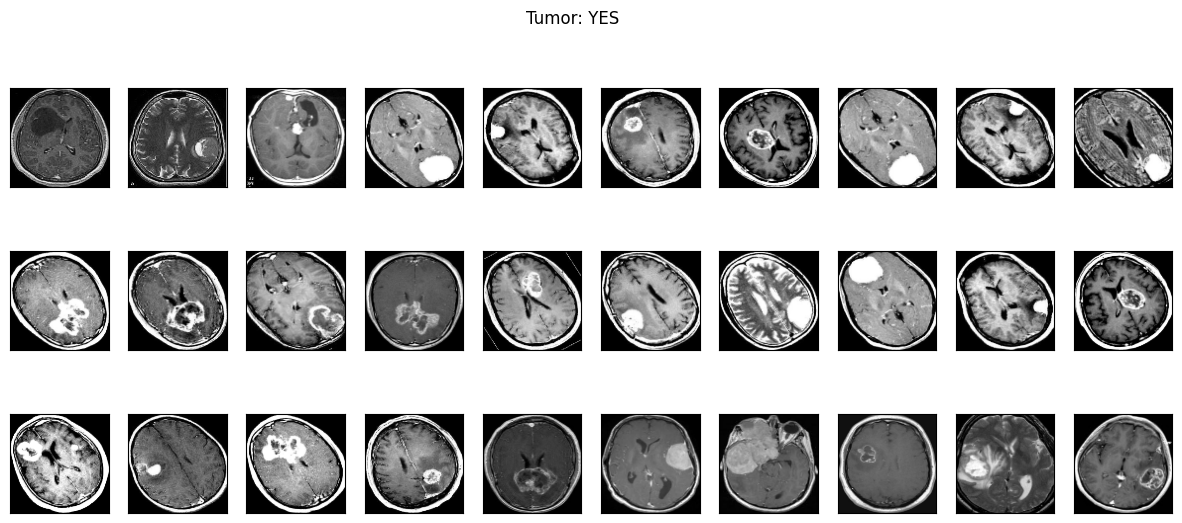

In [29]:
plot_samples(X_train_crop, y_train, labels, 30)

In [30]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [31]:
# saving new images to the folder
folders = [
    'TRAIN_CROP/YES', 'TRAIN_CROP/NO',
    'TEST_CROP/YES', 'TEST_CROP/NO',
    'VAL_CROP/YES', 'VAL_CROP/NO'
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("All folders created successfully.")

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

All folders created successfully.


<h2> Resizing the images </h2>

<p> Now that we have cropped the images, we can resize them without suffering from heavy distortions or resizing artefacts </p>

In [32]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)


In [33]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

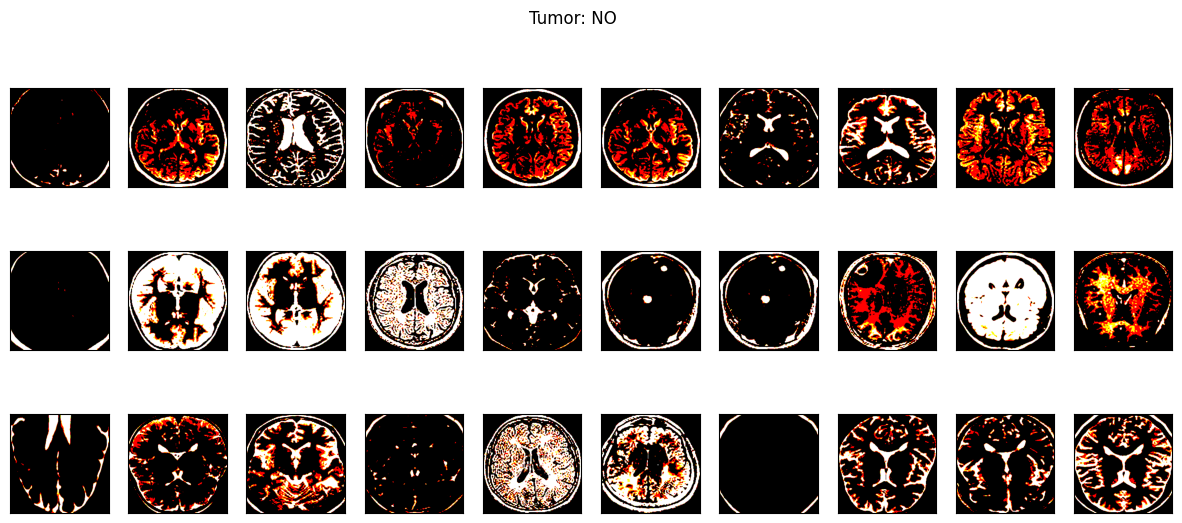

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

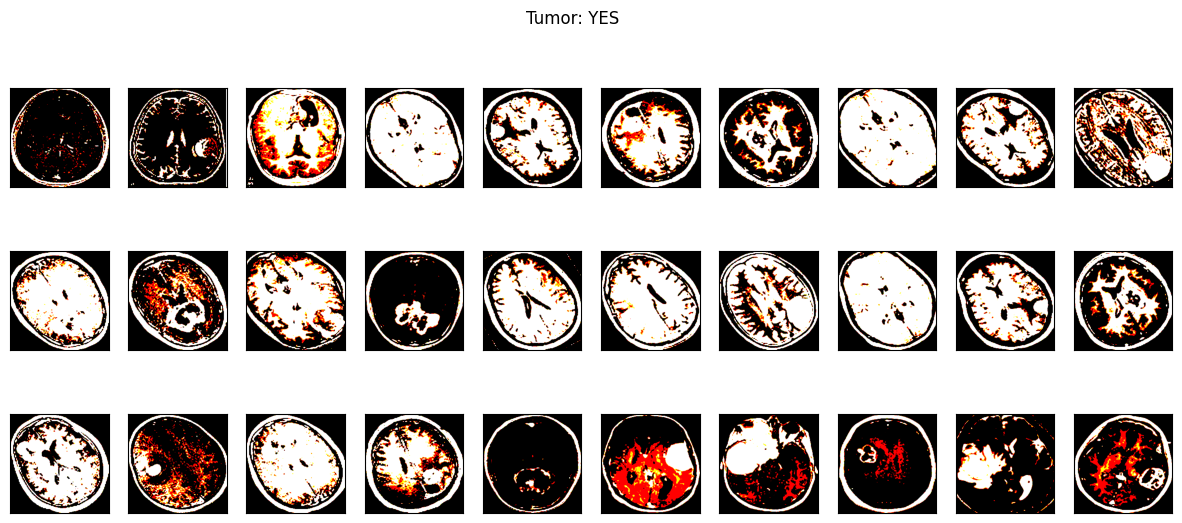

In [34]:
plot_samples(X_train_prep, y_train, labels, 30)

<h2> Image Augmentation </h2>
<p> We will perform data augmentation to increase the number of training samples we have </p>

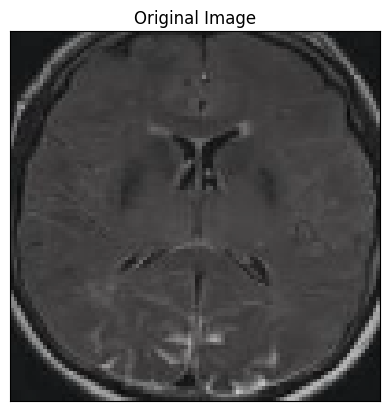

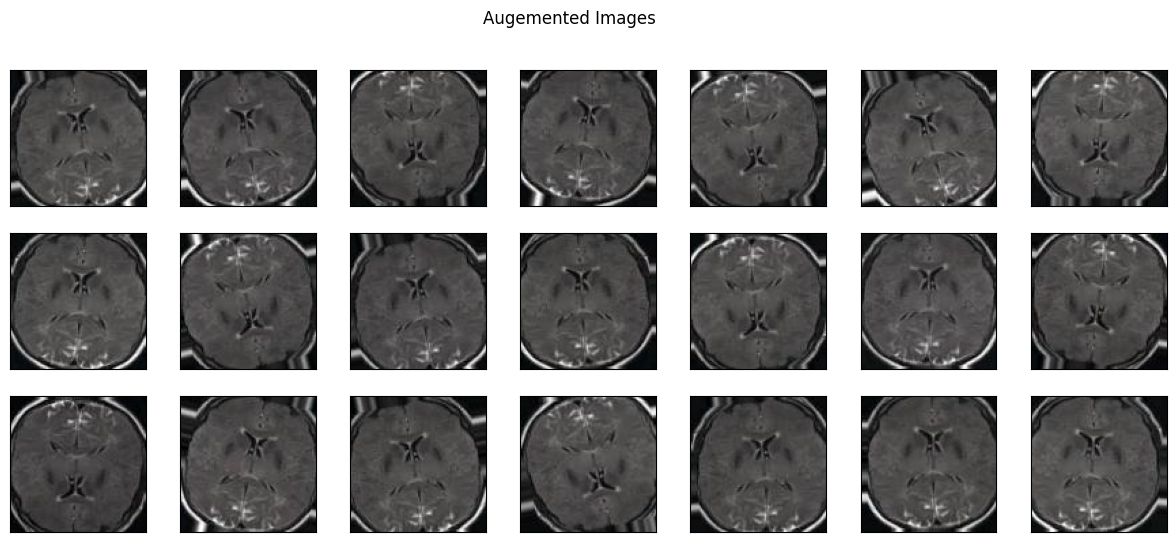

In [37]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
        
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()


In [38]:
!rm -rf preview/

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [39]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


<h2> Creating the model </h2>

<p> Here we will be using a pretrained ResNet50 model with ImageNet weights from keras. We will use transfer learning for this task. We will be using binary cross entropy as the loss function and accuracy and AUC as our monitoring metrics. </p>

In [40]:
base_Neural_Net= ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

    
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

<h2> TRAINING !!! </h2>

In [42]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30


c:\Users\saias\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



50/50 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - AUC: 0.8479 - accuracy: 0.7746 - loss: 0.5470 - val_AUC: 0.9593 - val_accuracy: 0.9050 - val_loss: 0.3178
Epoch 2/30


c:\Users\saias\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss



 7/50 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - AUC: 0.9433 - accuracy: 0.8456 - loss: 0.3288

c:\Users\saias\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 344ms/step - AUC: 0.9642 - accuracy: 0.8862 - loss: 0.2326 - val_AUC: 0.9682 - val_accuracy: 0.9000 - val_loss: 0.3077
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - AUC: 0.9639 - accuracy: 0.9067 - loss: 0.2410 - val_AUC: 0.9928 - val_accuracy: 0.9425 - val_loss: 0.1231
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - AUC: 0.9593 - accuracy: 0.9051 - loss: 0.2310 - val_AUC: 0.9954 - val_accuracy: 0.9600 - val_loss: 0.0888
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - AUC: 0.9793 - accuracy: 0.9204 - loss: 0.1911 - val_AUC: 0.9958 - val_accuracy: 0.9575 - val_loss: 0.1059
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 477ms/step - AUC: 0.9869 - accuracy: 0.9567 - loss: 0.1300 - val_AUC: 0.9965 - val_accuracy: 0.9700 - val_loss: 0.0821
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - AUC: 0.9799 - accuracy: 0.9377 - loss: 0.1804 - val_AUC: 0.9983 - val_accuracy: 0.9700 - val_loss: 0.0681
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 495ms/ste

<h2>Let's have a look at the performance of our model </h2>

<h3> Validating with the training set </h3>

57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step
Train Accuracy = 0.98


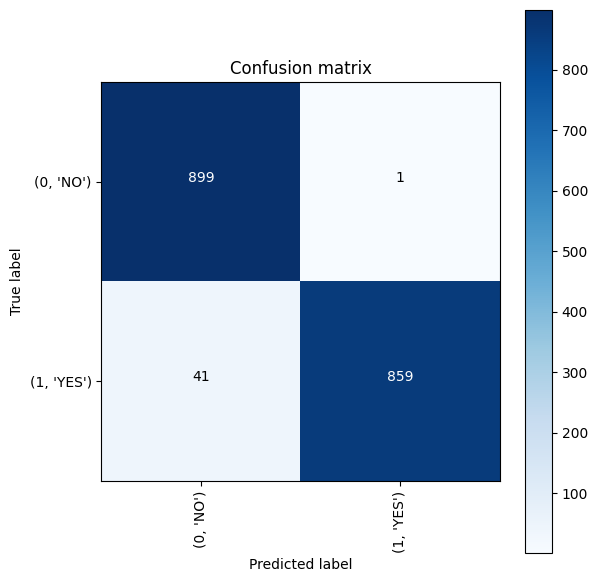

In [43]:
predictions = model.predict(X_train_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_train, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

<h3> Validating with the Validation set</h3>

19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
Val Accuracy = 0.96


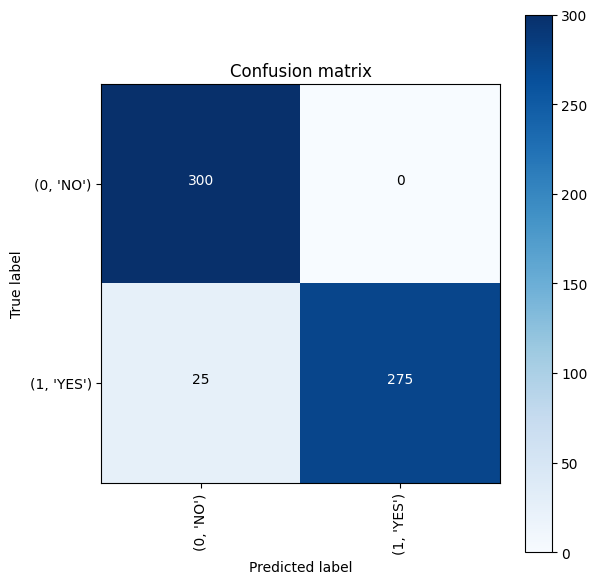

In [44]:
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

* <h3> Validating with the Test set</h3>

19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Test Accuracy = 0.95


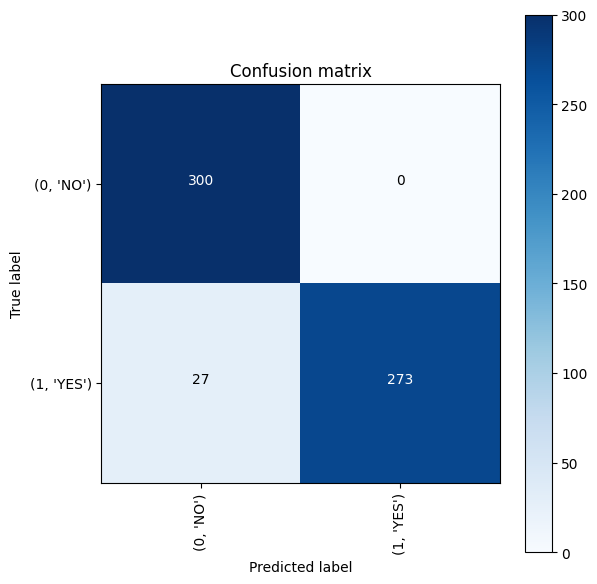

In [45]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [47]:
prob_pred = model.predict(X_test_prep)

19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


<h2> Let's see the other performance metrics on the test set </h2>

In [48]:
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test, predictions),4))
print('Precision score is :', np.round(metrics.precision_score(y_test, predictions, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test, predictions, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test, predictions, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test, prob_pred,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, predictions),4))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions))

Accuracy score is : 0.955
Precision score is : 0.9587
Recall score is : 0.955
F1 Score is : 0.9549
ROC AUC Score is : 0.9994
Cohen Kappa Score: 0.91
		Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       300
           1       1.00      0.91      0.95       300

    accuracy                           0.95       600
   macro avg       0.96      0.96      0.95       600
weighted avg       0.96      0.95      0.95       600



<h2> Conclusion </h2>
<p> A seen from the metrics, the model performs pretty well. We are able to correctly classify all the images in the test set with very few false positives and false negatives in the validation set. This performance can be firther enhanced by hyper parameter tuning. </p>

In [49]:
# clean up the space
folders_to_delete = [
    'TRAIN', 'TEST', 'VAL',
    'TRAIN_CROP', 'TEST_CROP', 'VAL_CROP'
]

for folder in folders_to_delete:
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"Deleted folder: {folder}")
    else:
        print(f"Folder not found: {folder}")

Deleted folder: TRAIN
Deleted folder: TEST
Deleted folder: VAL
Deleted folder: TRAIN_CROP
Deleted folder: TEST_CROP
Deleted folder: VAL_CROP
